In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as si
from scipy.stats import norm, lognorm
import datetime
from pyfinance.options import BSM
import warnings
warnings.filterwarnings('ignore')

In [ ]:
BSM()

In [2]:
def bs(S, E, T, r, sigma):
    d1 = (np.log(S/E) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S/E) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return S*norm.cdf(d1) - E*np.exp(-r*T)*norm.cdf(d2)

def vol(S, E, r, T, C):
    try:
        return si.optimize.bisect(f=lambda x: bs(S, E, T, r, x+1e-16)-C, a=10e-16, b=1e16)
    except ValueError:
        return np.nan

In [84]:
def read_data(path, sheet):
    file = pd.ExcelFile(path)
    df = file.parse(file.sheet_names[sheet])
    df.columns = ['T', *df.columns[1:-3], 'S', 'r', 'date']
    df.set_index(df['T'], inplace=True)
    return df

def process(df, E):
    df2 = df[['T', *E, 'S', 'r', 'date']]
    #df2 = df2.rename(columns={E:'C'})
    df2['S'] = df2['S']/1000
    df2['T'] = df2['T']/252
    for strike in E:
        df2[strike] = df2[strike]/1000
        #df2[f'sigma{strike}'] = df2.apply(lambda row: vol(row['S'], strike/1000, row['r'], row['T'], row[strike]), axis=1)
        df2[f'sigma{strike}'] = df2.apply(lambda row: BSM(row['S'], strike/1000, row['T'], row['r'], 0.5).implied_vol(row[strike]), axis=1)
    df2 = df2.dropna()
    for strike in E:
        df2 = df2[df2[f'sigma{strike}'] > 0]
        df2 = df2[df2[f'sigma{strike}'] < 0.6]
    return df2

def process_port(df, E):
    df2 = df[['T', E-20, E-10, E, E+10, E+20, 'S', 'r', 'date']]
    df2 = df2.rename(columns={E:'C', E-20: 'C-20', E-10: 'C-10', E+10: 'C+10', E+20: 'C+20'})
    df2['C'] = df2['C']/1000
    df2['S'] = df2['S']/1000
    df2['T'] = df2['T']/252
    df2['sigma'] = df2.apply(lambda row: vol(row['S'], E/1000, row['r'], row['T'], row[strike]), axis=1)
    df2 = df2.dropna()
    df2 = df2[df2['sigma'] > 0]
    #df2 = df2[df2['sigma'] < 0.6]
    return df2

def best_slice(df):
    start      = df.index[0]
    best_start = df.index[0]
    best_end   = df.index[0]
    prev       = df.index[0]
    
    for end in df.index:
        if start - end > best_start - best_end:
                best_start = start
                best_end = end
        if prev - end > 2:
            if start - end > best_start - best_end:
                best_end = prev
            start = end
            
        prev = end
    
    return df.loc[best_start:best_end]

In [55]:
ATM = {
    0:  520, # pm 10, 20, 30, 40
    1:  515, # all
    2:  520, # pm 10, 20, 30, 40
    3:  500, # pm 10, 20, 30, 40
    4:  530, # all
    5:  550, # pm 10, 20, more neg
    6:  520, # pm 10, 20
    7:  500, # all
    8:  485, # all
    9:  490, # pm 10, 20
    10: 515, # all
    11: 535, # all
}

In [5]:
sheet = 10
E = ATM[sheet]
df = read_data('isx2010C.xls', sheet)
df2 = process(df, [E])
df2 = df2.loc[45:]
df2

,T,515,S,r,date,sigma515
T,,,,,,
45,0.178571,0.01590,0.51636,0.15,20.9.2010,0.063183
44,0.174603,0.01565,0.51553,0.15,21.9.2010,0.076909
43,0.170635,0.01455,0.51383,0.15,22.9.2010,0.084999
42,0.166667,0.01280,0.50946,0.15,23.9.2010,0.106189
40,0.158730,0.01570,0.51649,0.16,27.9.2010,0.072913
39,0.154762,0.01620,0.51801,0.16,28.9.2010,0.061175
38,0.150794,0.01580,0.51631,0.16,29.9.2010,0.088812
37,0.146825,0.01470,0.51465,0.16,30.9.2010,0.096592
36,0.142857,0.01570,0.51722,0.16,1.10.2010,0.085452


In [490]:
BSM(S0=0.51934, K=0.515, r=0.16, T=0.162698, sigma=0.2).implied_vol(0.01700)

nan

In [496]:
vol(S=0.51934, E=0.515, r=0.16, T=0.162698, C=0.01700)

nan

In [507]:
amounts = []
skips = 0
new = True
for i, row in df2.iterrows():
    
    if skips == 0 or new:
    
        T = row['T']
        C = row['C']
        S = row['S']
        r = row['r']
        sigma = row['sigma']

        d1 = (np.log(S/(E/1000)) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        delta = norm.cdf(d1)
        
        skips = 0
        new = False
    
    else:
        
        skips += 1
        
    amounts.append(delta)
    
amounts = np.array(amounts)

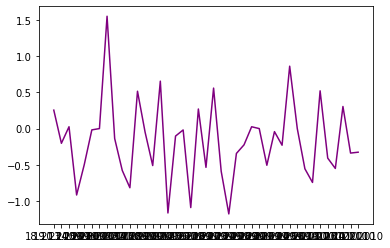

13.685460725328623

In [508]:
underlying_value_changes = df2['S'].values[1:] - df2['S'].values[:-1]
opt_value_changes        = df2['C'].values[1:] - df2['C'].values[:-1]

hedge_value_changes = underlying_value_changes * amounts[:-1]

date = df2['date'].values[1:]

#plt.plot(date, 1000*hedge_value_changes, color='r')
#plt.plot(date, 1000*opt_value_changes, color='b')
plt.plot(date, 1000*opt_value_changes-1000*hedge_value_changes, color='purple')
plt.show()

errors.append(np.sum(np.power(1000*opt_value_changes-1000*hedge_value_changes,2)))
np.sum(np.power(1000*opt_value_changes-1000*hedge_value_changes,2))

In [509]:
errors

[28.29548849044079, 13.685460725328623]

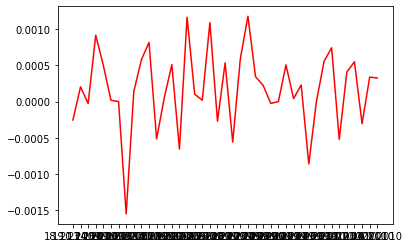

In [399]:
plt.plot(date, hedge_value_changes-opt_value_changes, color='r')
#plt.plot(date, 1000*opt_value_changes, color='b')
plt.show()

In [187]:
old = np.sum(np.power(opt_value_changes-hedge_value_changes,2))

In [191]:
old - np.sum(np.power(opt_value_changes-hedge_value_changes,2))

2.4933658792095515e-05

In [117]:
def delta_hedge(freq):
    errors = []
    changes = []
    for sheet in range(12):

        E = ATM[sheet]
        df = read_data('isx2010C.xls', sheet)
        df2 = process(df, [E])
        df2 = df2.loc[45:]
        #df2 = best_slice(df2)

        amounts = []
        day = 0
        for i, row in df2.iterrows():

            if day % freq == 0:

                T = row['T']
                C = row[E]
                S = row['S']
                r = row['r']
                sigma = row[f'sigma{E}']

                d1 = (np.log(S/(E/1000)) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
                delta = norm.cdf(d1)

            day += 1
            amounts.append(delta)

        amounts = np.array(amounts)
        
        option_value_changes = df2[E].values[1:] - df2[E].values[:-1]
        index_value_changes  = df2['S'].values[1:] - df2['S'].values[:-1]
        hedge_value_changes  = index_value_changes * amounts[:-1]
        
        # Flip sign of option changes due to the position being short
        differences = (1000*(-option_value_changes + hedge_value_changes))
        error = np.mean(np.power(differences, 2))
        
        change = np.sum(np.abs((amounts[1:] - amounts[:-1])*df2['S'].values[1:]))
        
        errors.append(error)
        changes.append(change)
    
    return np.array(errors), np.array(changes)

In [719]:
delta_hedge(1)

<ipython-input-714-d3a0e1f44965>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['S'] = df2['S']/1000
<ipython-input-714-d3a0e1f44965>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['T'] = df2['T']/252
<ipython-input-714-d3a0e1f44965>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

<ipython-input-714-d3a0e1f44965>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[f'sigma{strike}'] = df2.apply(lambda row: vol(row['S'], strike/1000, row['r'], row['T'], row[strike]), axis=1)
<ipython-input-714-d3a0e1f44965>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['S'] = df2['S']/1000
<ipython-input-714-d3a0e1f44965>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

<ipython-input-714-d3a0e1f44965>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[f'sigma{strike}'] = df2.apply(lambda row: vol(row['S'], strike/1000, row['r'], row['T'], row[strike]), axis=1)


array([0.33379173, 0.81276786, 0.73540009, 2.03177181, 3.56513627,
       1.80585317, 1.71372815, 1.27880292, 1.7818616 , 2.91671559,
       1.8863659 , 1.8265127 ])

In [98]:
errors1 = []
errors2 = []
for freq in range(1,11):
    print(freq)
    errors1.append(delta_hedge(freq))
    errors2.append(delta_vega_hedge(freq))

1
2
3
4
5
6
7
8
9
10


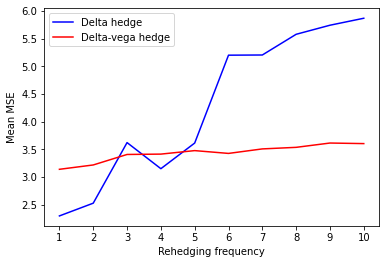

In [101]:
plt.plot(range(1,11),[np.mean(error) for error in errors1], color='blue', label='Delta hedge')
plt.plot(range(1,11),[np.mean([y for y in x if y==y]) for x in errors2], color='red', label='Delta-vega hedge')
plt.xticks(range(1,11))
plt.ylabel('Mean MSE')
plt.xlabel('Rehedging frequency')
plt.legend()
#plt.show()
plt.savefig('single-mean2.jpg', dpi=1000)

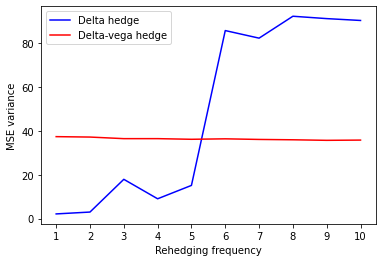

In [102]:
plt.plot(range(1,11),[np.var(error) for error in errors1], color='blue', label='Delta hedge')
plt.plot(range(1,11),[np.var([y for y in x if y==y]) for x in errors2], color='red', label='Delta-vega hedge')
plt.xticks(range(1,11))
plt.ylabel('MSE variance')
plt.xlabel('Rehedging frequency')
plt.legend()
#plt.show()
plt.savefig('single-var2.jpg', dpi=1000)

In [110]:
def delta_vega_hedge(freq):
    errors = []
    i_changes = []
    o_changes = []
    for sheet in range(11):

        E1 = ATM[sheet]
        
        df = read_data('isx2010C.xls', sheet)
        df2 = process(df, [E1])
        
        df = read_data('isx2010C.xls', sheet+1)
        df3 = process(df, [E1])
        
        df4 = pd.merge(df2, df3, on='date')
        
        df4.index = [int(x) for x in df4['T_y']*252]
        df4 = df4.loc[45:]
        #df4 = best_slice(df4)

        i_amounts = []
        o_amounts = []
        day = 0
        for i, row in df4.iterrows():

            if day % freq == 0:

                T1 = row['T_x']
                T2 = row['T_y']
                C1 = row[f'{E1}_x']
                C2 = row[f'{E1}_y']
                S = row['S_x']
                r = row['r_x']
                sigma1 = row[f'sigma{E1}_x']
                sigma2 = row[f'sigma{E1}_y']

                d11 = (np.log(S/(E1/1000)) + (r + 0.5*sigma1**2)*T1)/(sigma1*np.sqrt(T1))
                d12 = (np.log(S/(E1/1000)) + (r + 0.5*sigma2**2)*T2)/(sigma2*np.sqrt(T2))
                delta1 = norm.cdf(d11)
                delta2 = norm.cdf(d12)
                vega1 = S*np.sqrt(T1)*norm.pdf(d11)
                vega2 = S*np.sqrt(T2)*norm.pdf(d12)

            o_amounts.append(vega1/vega2)
            i_amounts.append(delta1-vega1/vega2*delta2)
            day += 1

        i_amounts = np.array(i_amounts)
        o_amounts = np.array(o_amounts)
        
        option_value_changes = df4[f'{E1}_x'].values[1:] - df4[f'{E1}_x'].values[:-1]
        index_value_changes  = df4['S_x'].values[1:] - df4['S_x'].values[:-1]
        repl_value_changes = df4[f'{E1}_y'].values[1:] - df4[f'{E1}_y'].values[:-1]
        hedge_value_changes  = index_value_changes * i_amounts[:-1] + repl_value_changes*o_amounts[:-1]
        
        # Flip sign of option changes due to the position being short
        differences = (1000*(-option_value_changes + hedge_value_changes))
        error = np.nanmean(np.square(differences))
        
        i_change = np.sum(np.abs(i_amounts[1:] - i_amounts[:-1]))
        o_change = np.sum(np.abs(o_amounts[1:] - o_amounts[:-1]))
        
        errors.append(error)
        i_changes.append(i_change)
        o_changes.append(o_change)
    
    return np.array(errors), np.array(i_changes), np.array(o_changes)

In [64]:
delta_vega_hedge(1)

0.057595113543512225
0.057595113543512225
0.056984861200181265
0.056984861200181265
0.05563819348112167
0.05563819348112167
0.05524584989405006
0.05524584989405006
0.053607796852593106
0.053607796852593106
0.05182141483857418
0.051821414838574185
0.05033109495199416
0.05033109495199416
0.04863068246404098
0.04863068246404098
0.04505085520655659
0.04505085520655659
0.04333831900041341
0.04333831900041341
0.0397830760642387
0.0397830760642387
0.03229973983044218
0.03229973983044218
0.0340118908215597
0.0340118908215597
0.027092464628821394
0.027092464628821394
0.02164730127265873
0.02164730127265873
0.02578068030634274
0.02578068030634274
0.014867143124311494
0.014867143124311493
0.006205768624759382
0.006205768624759382
0.03867025789930971
0.03867025789930971
0.050736916013597526
0.050736916013597526
0.06038336412255664
0.06038336412255664
0.054180697581618156
0.054180697581618156
0.053433193733945054
0.053433193733945054
0.04928427825230671
0.04928427825230672
0.050755439582293164
0.05

array([5.49115744e-02, 1.29281683e-01, 2.43130689e-02,            nan,
       1.54146932e+00, 4.61766456e-03, 4.71612698e-02, 4.95202803e-01,
       6.75452585e-01,            nan, 1.82463738e+01])

In [121]:
def delta_hedge_port(freq, strike_diffs):
    errors = []
    changes = []
    for sheet in range(12):
        E = np.array([ATM[sheet] + strike_diff for strike_diff in strike_diffs])
        df = read_data('isx2010C.xls', sheet)
        df2 = process(df, E)
        df2 = df2.loc[45:]
        #df2 = best_slice(df2)

        amounts = []
        day = 0
        for i, row in df2.iterrows():

            if day % freq == 0:

                T = row['T']
                C = row[E].values
                S = row['S']
                r = row['r']
                sigma = row[[f'sigma{strike}' for strike in E]].values

                d1 = (np.log(S/(E/1000)) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
                delta = np.sum(norm.cdf(d1.astype('float64')))
                
                #print(delta)

            day += 1
            amounts.append(delta)

        amounts = np.array(amounts)
        
        option_value_changes = np.sum(df2[E].values[1:] - df2[E].values[:-1], axis=1)
        index_value_changes  = df2['S'].values[1:] - df2['S'].values[:-1]
        hedge_value_changes  = index_value_changes * amounts[:-1]
        
        # Flip sign of option changes due to the position being short
        differences = (1000*(-option_value_changes + hedge_value_changes))
        error = np.nanmean(np.power(differences, 2))
        
        change = np.sum(np.abs((amounts[1:] - amounts[:-1])*df2['S'].values[1:]))
        
        errors.append(error)
        changes.append(change)
    
    return np.array(errors), np.array(changes)

In [122]:
def delta_vega_hedge_port(freq, strike_diffs):
    errors = []
    i_changes = []
    o_changes = []
    for sheet in range(11):
        E = np.array([ATM[sheet] + strike_diff for strike_diff in strike_diffs])
        
        df = read_data('isx2010C.xls', sheet)
        df2 = process(df, E)
        
        df = read_data('isx2010C.xls', sheet+1)
        df3 = process(df, [ATM[sheet]])
        
        df4 = pd.merge(df2, df3, on='date')
        
        df4.index = [int(x) for x in df4['T_y']*252]
        df4 = df4.loc[45:]
        #df4 = best_slice(df4)
        
        #print(df4)

        i_amounts = []
        o_amounts = []
        day = 0
        for i, row in df4.iterrows():

            if day % freq == 0:

                T1 = row['T_x']
                T2 = row['T_y']
                #C1 = row['C_x']
                #C2 = row['C_y']
                S = row['S_x']
                r = row['r_x']
                sigma1 = row[[f'sigma{strike}_x' if strike == ATM[sheet] else f'sigma{strike}' for strike in E]].values
                sigma2 = row[f'sigma{ATM[sheet]}_y']

                d11 = (np.log(S/(E/1000)) + (r + 0.5*sigma1**2)*T1)/(sigma1*np.sqrt(T1))
                d12 = (np.log(S/(ATM[sheet]/1000)) + (r + 0.5*sigma2**2)*T2)/(sigma2*np.sqrt(T2))
                delta1 = np.sum(norm.cdf(d11.astype('float64')))
                delta2 = norm.cdf(d12)
                vega1 = np.sum(S*np.sqrt(T1)*norm.pdf(d11.astype('float64')))
                vega2 = S*np.sqrt(T2)*norm.pdf(d12)
                
                #print(delta1)
                #print(delta2)
                #print()

            
            o_amounts.append(vega1/vega2)
            i_amounts.append(delta1-vega1/vega2*delta2)
            day += 1

        i_amounts = np.array(i_amounts)
        o_amounts = np.array(o_amounts)
        l = [f'{strike}_x' if strike == ATM[sheet] else strike for strike in E]
        #print(l)
        #print()
        option_value_changes = np.sum(df4[l].values[1:] - df4[l].values[:-1], axis=1)
        #option_value_changes = df4['C_x'].values[1:] - df4['C_x'].values[:-1]
        index_value_changes  = df4['S_x'].values[1:] - df4['S_x'].values[:-1]
        repl_value_changes = df4[f'{ATM[sheet]}_y'].values[1:] - df4[f'{ATM[sheet]}_y'].values[:-1]
        hedge_value_changes  = index_value_changes * i_amounts[:-1] + repl_value_changes*o_amounts[:-1]
        
        # Flip sign of option changes due to the position being short
        differences = (1000*(-option_value_changes + hedge_value_changes))
        error = np.nanmean(np.power(differences, 2))
        
        i_change = np.sum(np.abs((i_amounts[1:] - i_amounts[:-1])*df4['S_x'].values[1:]))
        o_change = np.sum(np.abs((o_amounts[1:] - o_amounts[:-1])*df4[f'{ATM[sheet]}_y'].values[1:]))
        
        errors.append(error)
        i_changes.append(i_change)
        o_changes.append(o_change)
    
    return np.array(errors), np.array(i_changes), np.array(o_changes)

In [124]:
changes1 = []
changes2 = []
for i in range(1,11):
    changes1.append(delta_hedge(i)[1])
    x = delta_vega_hedge(i)
    changes2.append(x[1]+x[2])

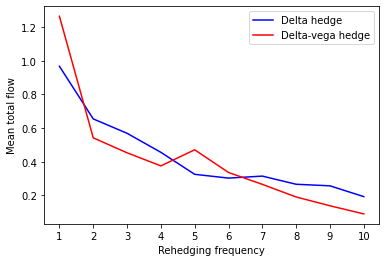

In [132]:
plt.plot(range(1,11),[np.mean(x) for x in changes1], color='blue', label='Delta hedge')
plt.plot(range(1,11),[np.mean(x) for x in changes2], color='red', label='Delta-vega hedge')
plt.xticks(range(1,11))
plt.ylabel('Mean total flow')
plt.xlabel('Rehedging frequency')
plt.legend()
plt.savefig('sep-cost-mean', dpi=1000)

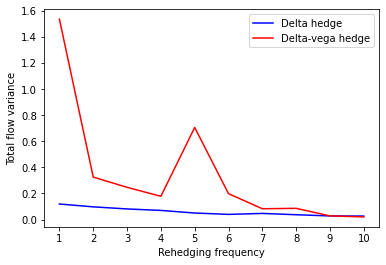

In [131]:
plt.plot(range(1,11),[np.var(x) for x in changes1], color='blue', label='Delta hedge')
plt.plot(range(1,11),[np.var(x) for x in changes2], color='red', label='Delta-vega hedge')
plt.xticks(range(1,11))
plt.ylabel('Total flow variance')
plt.xlabel('Rehedging frequency')
plt.legend()
plt.show()

In [ ]:
delta_vega_hedge_port(1, [-10, 0, 10])

In [105]:
errors3 = []
errors4 = []
for freq in range(1,11):
    print(freq)
    errors3.append(delta_hedge_port(freq, [-10, 0, 10]))
    errors4.append(delta_vega_hedge_port(freq, [-10, 0, 10]))

1
2
3
4
5
6
7
8
9
10


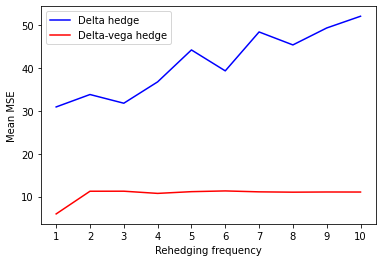

In [106]:
plt.plot(range(1,11),[np.mean(error) for error in errors3], color='blue', label='Delta hedge')
plt.plot(range(1,11),[np.mean([y for y in x if y==y]) for x in errors4], color='red', label='Delta-vega hedge')
plt.xticks(range(1,11))
plt.ylabel('Mean MSE')
plt.xlabel('Rehedging frequency')
plt.legend()
#plt.show()
plt.savefig('port-mean2.jpg', dpi=1000)

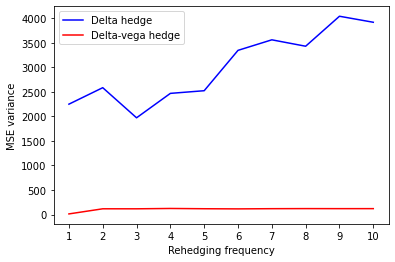

In [107]:
plt.plot(range(1,11),[np.var(error) for error in errors3], color='blue', label='Delta hedge')
plt.plot(range(1,11),[np.var([y for y in x if y==y]) for x in errors4], color='red', label='Delta-vega hedge')
plt.xticks(range(1,11))
plt.ylabel('MSE variance')
plt.xlabel('Rehedging frequency')
plt.legend()
#plt.show()
plt.savefig('port-var2.jpg', dpi=1000)

In [811]:
plt.plot(range(1,6),[np.mean(error) for error in errors3], color='blue', label='Delta hedge')
plt.plot(range(1,6),[np.mean([y for y in x if y==y]) for x in errors4], color='red', label='Delta-vega hedge')
plt.xticks(range(1,6))
plt.ylabel('Mean MSE')
plt.xlabel('Rehedging frequency')
plt.legend()
#plt.show()
plt.savefig('port-mean.jpg', dpi=1000)

,T,515,S,r,date,sigma515
T,,,,,,
45,0.178571,0.01330,0.51394,0.04,21.12.2009,0.138319
44,0.174603,0.01360,0.51515,0.04,22.12.2009,0.136029
43,0.170635,0.01365,0.51544,0.04,23.12.2009,0.136772
42,0.166667,0.01500,0.51816,0.04,24.12.2009,0.136065
41,0.162698,0.01500,0.51816,0.07,25.12.2009,0.119283
40,0.158730,0.01550,0.51913,0.07,28.12.2009,0.120144
39,0.154762,0.01495,0.51875,0.07,29.12.2009,0.118895
38,0.150794,0.01438,0.51890,0.07,30.12.2009,0.112587
37,0.146825,0.01290,0.51409,0.07,31.12.2009,0.135212


In [39]:
errors2 = []
errors3 = []
for freq in range(1,6):
    print(freq)
    errors2.append(delta_hedge_port(freq, [0]))
    errors3.append(delta_vega_hedge_port(freq, [0]))

1
2
3
4
5


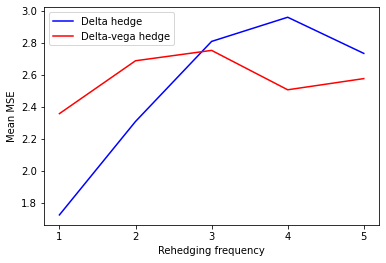

In [41]:
plt.plot(range(1,6),[np.mean(error) for error in errors2], color='blue', label='Delta hedge')
plt.plot(range(1,6),[np.mean([y for y in x if y==y]) for x in errors3], color='red', label='Delta-vega hedge')
plt.xticks(range(1,6))
plt.ylabel('Mean MSE')
plt.xlabel('Rehedging frequency')
plt.legend()
#plt.show()
plt.savefig('single-mean.jpg', dpi=1000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


30 1 505
30 1 530
30 1 485
30 1 520
30 1 545
30 1 525
30 1 475
30 1 490
30 1 510
30 1 500
30 1 525
30 1 550
30 2 505
30 2 530
30 2 485
30 2 520
30 2 545
30 2 525
30 2 475
30 2 490
30 2 510
30 2 500
30 2 525
30 2 550
30 3 505
30 3 530
30 3 485
30 3 520
30 3 545
30 3 525
30 3 475
30 3 490
30 3 510
30 3 500
30 3 525
30 3 550
30 4 505
30 4 530
30 4 485
30 4 520
30 4 545
30 4 525
30 4 475
30 4 490
30 4 510
30 4 500
30 4 525
30 4 550
30 5 505
30 5 530
30 5 485
30 5 520
30 5 545
30 5 525
30 5 475
30 5 490
30 5 510
30 5 500
30 5 525
30 5 550
30 6 505
30 6 530
30 6 485
30 6 520
30 6 545
30 6 525
30 6 475
30 6 490
30 6 510
30 6 500
30 6 525
30 6 550
30 7 505
30 7 530
30 7 485
30 7 520
30 7 545
30 7 525
30 7 475
30 7 490
30 7 510
30 7 500
30 7 525
30 7 550
30 8 505
30 8 530
30 8 485
30 8 520
30 8 545
30 8 525
30 8 475
30 8 490
30 8 510
30 8 500
30 8 525
30 8 550
30 9 505
30 9 530
30 9 485
30 9 520
30 9 545
30 9 525
30 9 475
30 9 490
30 9 510
30 9 500
30 9 525
30 9 550
30 10 505
30 10 530
30 10 48

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


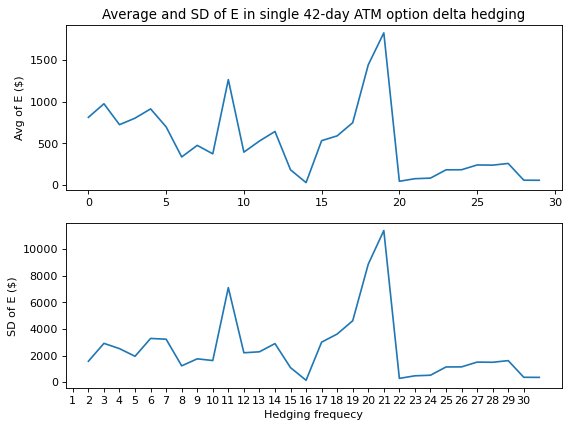

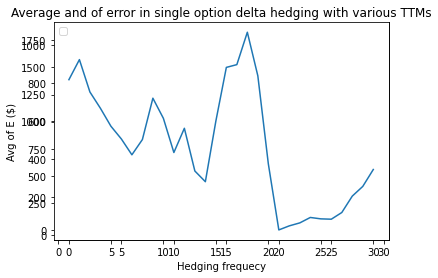

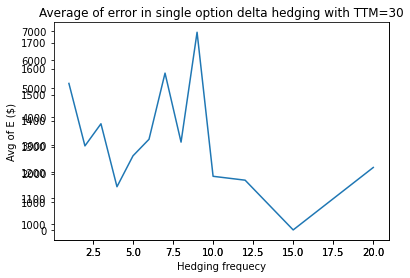

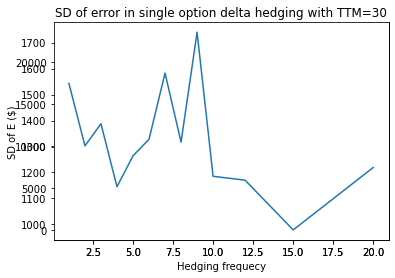

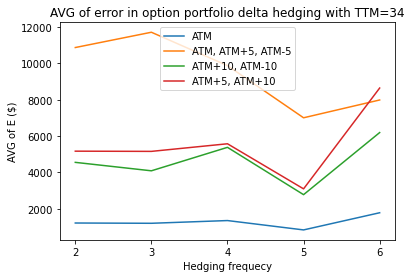

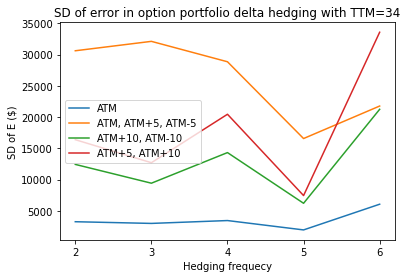

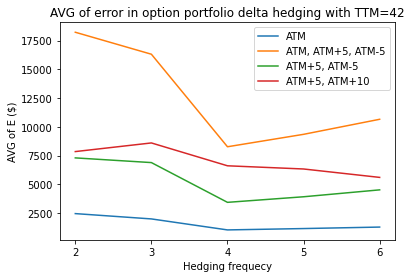

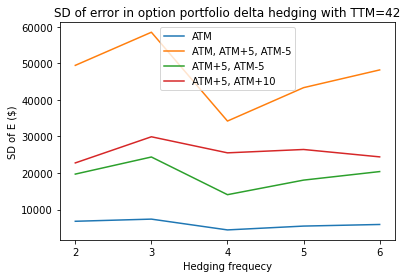

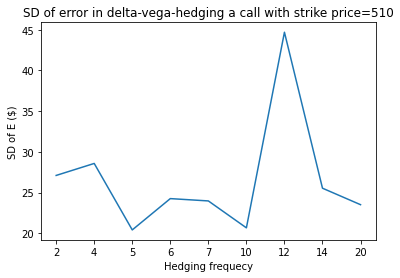

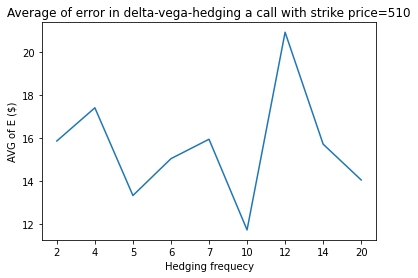

In [52]:
#load libraries
import pandas as pd
import numpy as np
import scipy.stats as si
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

make_figures = True
data = None
#function for data loading

def loadData(filename, sheet_index):
	global data
	xls = pd.ExcelFile(filename)
	data = xls.parse(xls.sheet_names[sheet_index])
	data.columns = ['TTM', *data.columns[1:-3], 'SP', 'r', 'obs_date']
	data.set_index(list(data)[0], inplace=True)
	data.head()

#Find implied volatility using Newton's method
def impliedVolatility(C, S, K, T, r, max_error, max_iterations):
	sigma = 0.5
	for i in range(0, max_iterations):
		d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
		C1 = euroCallBS(S, K, T, r, sigma)
		vega = S * np.sqrt(T) * si.norm.cdf(d1, 0.0, 1.0)
		diff = C - C1
		if (abs(diff) < max_error):
			return sigma
		sigma = sigma + diff / vega
	return sigma

#Black-Scholes for an non-dividend paying European call option
def euroCallBS(S, K, T, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

#returns mean squared error for delta hedging in given worksheet, TTM, hedging frequency and strike price.
def deltaHedge(time_to_maturity, hedging_frequency, strike_price):

	K = strike_price
	subset = data.loc[time_to_maturity:, [strike_price, 'SP', 'r']]

	#initialize in-function variables
	first_day = True
	A, OP, RE, deltas = [], [], [], []
	days_to_hedge, i, last_delta, last_delta = 0, 0, 0, 0

	for index, row in subset.iterrows():
		S = row['SP']
		C = row[strike_price]
		T = index/365
		r = row['r']/1000

		# calculate new delta, if days to hedge are 0:
		if days_to_hedge == 0:
			# print ('Hedge!')
			days_to_hedge = hedging_frequency
			sigma = impliedVolatility(C, S, strike_price, T, r, 0.001, 100)
			d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
			delta = si.norm.cdf(d1, 0.0, 1.0)
			last_delta = delta
			last_sigma = sigma

		#else, use last calculated values
		else:
			sigma = last_sigma
			delta = last_delta

		OP.append(C)
		RE.append(S * delta)
		deltas.append(delta)

		#compute Ai, if not in first day
		if first_day:
			first_day = False
		else:
			diff_A = OP[i] - OP[i-1] - (RE[i] - RE[i-1])
			A.append(diff_A)

		#increase/decrease counters
		days_to_hedge = days_to_hedge - 1
		i = i+1

	return np.nanmean(np.square(A)), np.nanstd(np.square(A))


def deltaHedgePortfolio(time_to_maturity, hedging_frequency, strike_prices):
	As = {}
	for strike_price in strike_prices:
		As[str(strike_price)] = []
	for strike_price in strike_prices:
		K = strike_price
		subset = data.loc[time_to_maturity:, [strike_price, 'SP', 'r']]

		#initialize in-function variables
		first_day = True
		A, OP, RE, deltas = [], [], [], []
		days_to_hedge, i, last_delta, last_delta = 0, 0, 0, 0

		for index, row in subset.iterrows():
			S = row['SP']
			C = row[strike_price]
			T = index/365
			r = row['r']/1000

			# calculate new delta, if days to hedge are 0:
			if days_to_hedge == 0:
				# print ('Hedge!')
				days_to_hedge = hedging_frequency
				sigma = impliedVolatility(C, S, strike_price, T, r, 0.001, 100)
				d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
				delta = si.norm.cdf(d1, 0.0, 1.0)
				last_delta = delta
				last_sigma = sigma

			#else, use last calculated values
			else:
				sigma = last_sigma
				delta = last_delta

			OP.append(C)
			RE.append(S * delta)
			deltas.append(delta)

			#compute Ai, if not in first day
			if first_day:
				first_day = False
			else:
				diff_A = OP[i] - OP[i-1] - (RE[i] - RE[i-1])
				A.append(diff_A)
				As[str(strike_price)].append(diff_A)

			#increase/decrease counters
			days_to_hedge = days_to_hedge - 1
			i = i+1
	totalAs = As[str(strike_prices[0])]
	for j in range(1, len(strike_prices)):
		totalAs = np.add(totalAs, As[str(strike_prices[j])])
	return np.nanmean(np.square(totalAs)), np.nanstd(np.square(totalAs))

def deltaVegaHedge(T1, T2, hedging_frequency):

	#load replicating option series:
	loadData('isx2010C.xls', T2[2])
	replicating = data.loc[T2[0]:, T2[1]]

	#load original option series:
	loadData('isx2010C.xls', T1[2])
	original = data.loc[T1[0]:, [T1[1], 'SP', 'r']]

	#initialize in-function variables
	first_day = True
	K = T1[1]
	A, stocks, options, replicatings = [0], [], [], []
	days_to_hedge, i, last_delta_bs, last_kappa_bs, last_sigma, last_delta_rep, last_kappa_rep = 0, 0, 0, 0, 0, 0, 0
	alphas, etas = [], []
	for index, row in original.iterrows():
		S = row['SP']
		C = row[K]
		T = index/252
		r = row['r']/100

		C_rep = replicating.iloc[i]

		# calculate new parameters if days to hedge are 0:
		if days_to_hedge == 0:
			days_to_hedge = hedging_frequency
			sigma = impliedVolatility(C, S, K, T, r, 0.001, 100)
			sigma_rep = impliedVolatility(C_rep, S, K, T, r, 0.001, 100)
			d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
			d1_rep = (np.log(S / K) + (r + 0.5 * sigma_rep ** 2) * T) / (sigma * np.sqrt(T))
			
			delta_bs = si.norm.cdf(d1, 0.0, 1.0)
			kappa_bs = S * np.sqrt(T) * si.norm.pdf(d1, 0.0, 1.0)

			delta_rep = si.norm.cdf(d1_rep, 0.0, 1.0)
			kappa_rep = S * np.sqrt(T) * si.norm.pdf(d1_rep, 0.0, 1.0)

			last_delta_bs, last_delta_rep = delta_bs, delta_rep
			last_sigma = sigma
			last_kappa_bs, last_kappa_rep = kappa_bs, kappa_rep

		#else, use last calculated values
		else:
			sigma = last_sigma
			delta_bs, delta_rep = last_delta_bs, last_delta_rep
			kappa_bs, kappa_rep = last_kappa_bs, last_kappa_rep

		alpha = -1 * delta_bs + ( kappa_bs / kappa_rep ) * delta_rep
		eta = -1 * kappa_bs / kappa_rep
		alphas.append(alpha)
		etas.append(eta)

		stocks.append(alpha * S)
		options.append(C)
		replicatings.append(eta * C_rep)

		#compute Ai, if not in first day
		if first_day:
			first_day = False
		else:
			diff_A = options[i] - options[i-1] - (stocks[i] - stocks[i-1]) - (replicatings[i] - replicatings[i-1])
			A.append(diff_A)

		#increase/decrease counters
		days_to_hedge = days_to_hedge - 1
		i = i+1

	return np.nanmean(np.square(A)), np.nanstd(np.square(A)), alphas, etas

loadData('isx2010C.xls', 0)

if make_figures:
	#create fig 1
	hfs, avg, std = [], [], []
	for hf in range(1,31):
		a, s = deltaHedge(42, hf, 510)
		avg.append(a)
		std.append(s)
		hfs.append(hf)

	xi = list(range(len(hfs)))
	plt.figure(1)
	plt.subplot(211)
	plt.plot(avg)
	plt.title('Average and SD of E in single 42-day ATM option delta hedging')
	plt.ylabel('Avg of E ($)')
	plt.subplot(212)
	plt.plot(hfs, std)
	plt.ylabel('SD of E ($)')
	plt.xlabel('Hedging frequecy')
	plt.xticks(xi, hfs)
	plt.savefig('fig-1.eps', dpi=None, facecolor='w', edgecolor='w',
	        orientation='portrait', papertype=None, format=None,
	        transparent=False, bbox_inches=None, pad_inches=0.1,
	        metadata=None)

	#create figure 2
	ttms = [42,41,40,39,38]
	std_scatters = {}
	avg_scatters = {}
	avgs = []
	hfs = []
	for t in ttms:
		avg_scatters[str(t)] = []
		std_scatters[str(t)] = []
	for hf in range(1,31):
		avgs.append(0)
		for t in ttms:
			a, s = deltaHedge(t, hf, 510)
			avg_scatters[str(t)].append(a)
			std_scatters[str(t)].append(s)
			avgs[hf-1] = avgs[hf-1]+a/len(ttms)
		hfs.append(hf)
	fig = plt.figure()
	ax = fig.add_subplot(111)
	for t in ttms:
		ax.scatter(hfs, avg_scatters[str(t)], label='TTM: '+str(t))
	avr = fig.add_subplot(111)
	avr.plot(avgs)
	plt.title('Average and of error in single option delta hedging with various TTMs')
	plt.ylabel('Avg of E ($)')
	plt.xlabel('Hedging frequecy')
	plt.legend(loc='upper left');
	plt.savefig('fig-2.eps', dpi=None, facecolor='w', edgecolor='w',
	        orientation='portrait', papertype=None, format=None,
	        transparent=False, bbox_inches=None, pad_inches=0.1,
	        metadata=None)

	ttm = 30
	ts = 12 #nro of sheets
	#for each sheet, calculate atm value at ttm
	avgs, avg_scatters, std_scatters = {}, {}, {}
	hfs = [1,2,3,4,5,6,7,8,9,10,12,15,20]
	for t in range(0,ts):
		avg_scatters[str(t)] = []
		std_scatters[str(t)] = []
		
	for hf in hfs:
		avgs[str(hf)] = 0
		for t in range(0,ts):
			try:
				loadData('isx2010C.xls', t)
				atm = int(round(data.loc[ttm,'SP']/5)*5)
				print(ttm, hf, atm)
				a, s = deltaHedge(ttm, hf, atm)
				avg_scatters[str(t)].append(a)
				std_scatters[str(t)].append(s)
				avgs[str(hf)] = avgs[str(hf)]+a/ts
			except:
				print('Failure')

	fig = plt.figure()
	ax = fig.add_subplot(111)
	for t in range(0,ts):
		ax.scatter(hfs, avg_scatters[str(t)], c='black', label='TTM: '+str(t))
	avr = fig.add_subplot(111)
	arr = list(avgs.values())
	avr.plot(hfs, arr)
	plt.title('Average of error in single option delta hedging with TTM='+str(ttm))
	plt.ylabel('Avg of E ($)')
	plt.xlabel('Hedging frequecy')
	plt.savefig('fig-3.eps', dpi=None, facecolor='w', edgecolor='w',
	        orientation='portrait', papertype=None, format=None,
	        transparent=False, bbox_inches=None, pad_inches=0.1,
	        metadata=None)

	fig = plt.figure()
	ax = fig.add_subplot(111)
	for t in range(0,ts):
		ax.scatter(hfs, std_scatters[str(t)], c='black', label='TTM: '+str(t))
	avr = fig.add_subplot(111)
	arr = list(avgs.values())
	avr.plot(hfs, arr)
	plt.title('SD of error in single option delta hedging with TTM='+str(ttm))
	plt.ylabel('SD of E ($)')
	plt.xlabel('Hedging frequecy')
	plt.savefig('fig-4.eps', dpi=None, facecolor='w', edgecolor='w',
	        orientation='portrait', papertype=None, format=None,
	        transparent=False, bbox_inches=None, pad_inches=0.1,
	        metadata=None)

	loadData('isx2010C.xls', 9)
	ttm = 34
	K = 510

	ATM = { 'std': [], 'avg' : []}
	ATM5 = { 'std': [], 'avg' : []}
	ATM10 = { 'std': [], 'avg' : []}
	ATM15 = { 'std': [], 'avg' : []}
	hfs = [2,3,4,5,6]
	for hf in hfs:
		atm = deltaHedgePortfolio(ttm, hf, [K])
		atm5 = deltaHedgePortfolio(ttm, hf, [K- 5, K, K+5])
		atm10 = deltaHedgePortfolio(ttm, hf, [K - 10 , K + 10])
		atm15 = deltaHedgePortfolio(ttm, hf, [K + 5, K + 10])	

		ATM['avg'].append(atm[0])
		ATM['std'].append(atm[1])
		ATM5['avg'].append(atm5[0])
		ATM5['std'].append(atm5[1])
		ATM10['avg'].append(atm10[0])
		ATM10['std'].append(atm10[1])
		ATM15['avg'].append(atm15[0])
		ATM15['std'].append(atm15[1])
	plt.figure()
	plt.plot(ATM['avg'], label='ATM')
	plt.plot(ATM5['avg'], label='ATM, ATM+5, ATM-5')
	plt.plot(ATM10['avg'], label='ATM+10, ATM-10')
	plt.plot(ATM15['avg'], label='ATM+5, ATM+10')
	plt.xticks(np.arange(len(hfs)), hfs),
	plt.title('AVG of error in option portfolio delta hedging with TTM='+str(ttm))
	plt.ylabel('AVG of E ($)')
	plt.xlabel('Hedging frequecy')
	plt.legend()
	plt.savefig('fig-7.eps', dpi=None, facecolor='w', edgecolor='w',
		        orientation='portrait', papertype=None, format=None,
		        transparent=False, bbox_inches=None, pad_inches=0.1,
		        metadata=None)

	plt.figure()
	plt.plot(ATM['std'], label='ATM')
	plt.plot(ATM5['std'], label='ATM, ATM+5, ATM-5')
	plt.plot(ATM10['std'], label='ATM+10, ATM-10')
	plt.plot(ATM15['std'], label='ATM+5, ATM+10')
	plt.xticks(np.arange(len(hfs)), hfs),
	plt.title('SD of error in option portfolio delta hedging with TTM='+str(ttm))
	plt.ylabel('SD of E ($)')
	plt.xlabel('Hedging frequecy')
	plt.legend()
	plt.savefig('fig-8.eps', dpi=None, facecolor='w', edgecolor='w',
		        orientation='portrait', papertype=None, format=None,
		        transparent=False, bbox_inches=None, pad_inches=0.1,
		        metadata=None)

	loadData('isx2010C.xls', 10)

	ATM = { 'std': [], 'avg' : []}
	ATM5 = { 'std': [], 'avg' : []}
	ATM10 = { 'std': [], 'avg' : []}
	ATM15 = { 'std': [], 'avg' : []}
	hfs = [2,3,4,5,6]
	for hf in hfs:
		atm = deltaHedgePortfolio(42, hf, [535])
		atm5 = deltaHedgePortfolio(42, hf, [535, 530, 540])
		atm10 = deltaHedgePortfolio(42, hf, [530, 540])
		atm15 = deltaHedgePortfolio(42, hf, [540, 545])	

		ATM['avg'].append(atm[0])
		ATM['std'].append(atm[1])
		ATM5['avg'].append(atm5[0])
		ATM5['std'].append(atm5[1])
		ATM10['avg'].append(atm10[0])
		ATM10['std'].append(atm10[1])
		ATM15['avg'].append(atm15[0])
		ATM15['std'].append(atm15[1])
	plt.figure()
	plt.plot(ATM['avg'], label='ATM')
	plt.plot(ATM5['avg'], label='ATM, ATM+5, ATM-5')
	plt.plot(ATM10['avg'], label='ATM+5, ATM-5')
	plt.plot(ATM15['avg'], label='ATM+5, ATM+10')
	plt.xticks(np.arange(len(hfs)), hfs),
	plt.title('AVG of error in option portfolio delta hedging with TTM=42')
	plt.ylabel('AVG of E ($)')
	plt.xlabel('Hedging frequecy')
	plt.legend()
	plt.savefig('fig-5.eps', dpi=None, facecolor='w', edgecolor='w',
		        orientation='portrait', papertype=None, format=None,
		        transparent=False, bbox_inches=None, pad_inches=0.1,
		        metadata=None)

	plt.figure()
	plt.plot(ATM['std'], label='ATM')
	plt.plot(ATM5['std'], label='ATM, ATM+5, ATM-5')
	plt.plot(ATM10['std'], label='ATM+5, ATM-5')
	plt.plot(ATM15['std'], label='ATM+5, ATM+10')
	plt.xticks(np.arange(len(hfs)), hfs)
	plt.title('SD of error in option portfolio delta hedging with TTM=42')
	plt.ylabel('SD of E ($)')
	plt.xlabel('Hedging frequecy')
	plt.legend()
	plt.savefig('fig-6.eps', dpi=None, facecolor='w', edgecolor='w',
		        orientation='portrait', papertype=None, format=None,
		        transparent=False, bbox_inches=None, pad_inches=0.1,
		        metadata=None)

	T1 = (41, 510, 0) #original option: TTM, strike price, sheet index
	T2 = (65, 510, 1) #replicating option:  TTM, strike price, sheet index
	avgs, stds = [], []
	hfs = [2,4,5,6,7,10,12,14,20]
	for t in hfs:
		(a, s, alphas, etas) = deltaVegaHedge(T1, T2, t)
		avgs.append(a)
		stds.append(s)
	plt.figure()
	plt.plot(stds)
	plt.title('SD of error in delta-vega-hedging a call with strike price='+str(T1[1]))
	plt.ylabel('SD of E ($)')
	plt.xlabel('Hedging frequecy')
	plt.xticks(np.arange(len(hfs)), hfs)
	plt.savefig('fig-9.eps', dpi=None, facecolor='w', edgecolor='w',
		        orientation='portrait', papertype=None, format=None,
		        transparent=False, bbox_inches=None, pad_inches=0.1,
		        metadata=None)

	plt.figure()
	plt.plot(avgs)
	plt.title('Average of error in delta-vega-hedging a call with strike price='+str(T1[1]))
	plt.ylabel('AVG of E ($)')
	plt.xlabel('Hedging frequecy')
	plt.xticks(np.arange(len(hfs)), hfs)
	plt.savefig('fig-10.eps', dpi=None, facecolor='w', edgecolor='w',
		        orientation='portrait', papertype=None, format=None,
		        transparent=False, bbox_inches=None, pad_inches=0.1,
		        metadata=None)


In [93]:
errors2

[array([ 0.05486623,  0.18377152,  0.02436699,         nan,  2.58738806,
                nan,         nan,  0.46228642,  0.67534249,         nan,
        17.98902994]),
 array([ 0.06159852,  0.2915556 ,  0.03396406,         nan,  2.95414788,
                nan,         nan,  0.46602728,  0.72912757,         nan,
        17.98902994]),
 array([ 0.04339822,  1.27978778,  0.03857793,         nan,  3.29497051,
                nan,         nan,  0.45326135,  0.75338779,         nan,
        17.98902994]),
 array([ 0.04998714,  1.34797568,  0.03963673,         nan,  3.33168101,
                nan,         nan,  0.43125655,  0.70811693,         nan,
        17.98902994]),
 array([ 0.07431728,  1.31900061,  0.05127082,         nan,  3.42382297,
                nan,         nan,  0.80154311,  0.68028482,         nan,
        17.98902994]),
 array([ 0.06391277,  1.43382011,  0.04809644,         nan,  3.2991268 ,
                nan,         nan,  0.47484253,  0.6767435 ,         nan,
        1

In [65]:
def delta_vega_hedge(freq):
    errors = []
    for sheet in range(11):

        E1 = ATM[sheet]
        
        df = read_data('isx2010C.xls', sheet)
        df2 = process(df, [E1])
        
        df = read_data('isx2010C.xls', sheet+1)
        df3 = process(df, [E1])
        
        df4 = pd.merge(df2, df3, on='date')
        
        df4.index = [int(x) for x in df4['T_y']*252]
        df4 = df4.loc[45:]
        #df4 = best_slice(df4)

        i_amounts = []
        o_amounts = []
        day = 0
        for i, row in df4.iterrows():

            if day % freq == 0:

                T1 = row['T_x']
                T2 = row['T_y']
                C1 = row[f'{E1}_x']
                C2 = row[f'{E1}_y']
                S = row['S_x']
                r = row['r_x']
                sigma1 = row[f'sigma{E1}_x']
                sigma2 = row[f'sigma{E1}_y']

                d11 = (np.log(S/(E1/1000)) + (r + 0.5*sigma1**2)*(45/252))/(sigma1*np.sqrt(T1))
                d12 = (np.log(S/(E1/1000)) + (r + 0.5*sigma2**2)*(45/252))/(sigma2*np.sqrt(T2))
                delta1 = norm.cdf(d11)
                delta2 = norm.cdf(d12)
                vega1 = S*np.sqrt(T1)*norm.pdf(d11)
                vega2 = S*np.sqrt(T2)*norm.pdf(d12)

            o_amounts.append(vega1/vega2)
            i_amounts.append(delta1-vega1/vega2*delta2)
            day += 1

        i_amounts = np.array(i_amounts)
        o_amounts = np.array(o_amounts)
        
        option_value_changes = df4[f'{E1}_x'].values[1:] - df4[f'{E1}_x'].values[:-1]
        index_value_changes  = df4['S_x'].values[1:] - df4['S_x'].values[:-1]
        repl_value_changes = df4[f'{E1}_y'].values[1:] - df4[f'{E1}_y'].values[:-1]
        hedge_value_changes  = index_value_changes * i_amounts[:-1] + repl_value_changes*o_amounts[:-1]
        
        # Flip sign of option changes due to the position being short
        differences = (1000*(-option_value_changes + hedge_value_changes))
        error = np.mean(np.square(differences))
        
        errors.append(error)
    
    return np.array(errors)

In [58]:
delta

0.6655706898167991
0.08807404769293309
0.4076602962869232
0.48016875364802714
0.6636404605901907
0.10117939844665969
0.429265504253183
0.4943732718085766
0.6550363821499676
0.10650983009346077
0.4318894320308392
0.4967351597622927
0.656977361597219
0.14665665063820682
0.497256045380725
0.5336552143747448
0.6542129645737484
0.1466381872449809
0.5221516262581251
0.573992658885642
0.644374289739376
0.16713621163491965
0.5470672524494902
0.5896123524236785
0.6306809967633593
0.16644386918027942
0.5317369828150008
0.5792042498654588
0.6181433278465339
0.17261543832678605
0.5325314159765676
0.5822532759572836
0.5732634817573296
0.11085049086838861
0.3979853676258385
0.5008776695093899
0.5592436550842413
0.11483133788751887
0.3998948246616181
0.5097303906490612
0.5610640519397412
0.2915508951013935
0.665099966581732
0.6657868565788243
0.4906461791682241
0.41357462128212563
0.7625242032284942
0.7112041156377311
0.5175362106716005
0.34469894707022875
0.7082668559842006
0.7024975285152978
0.4481

0.7200558726785777
0.028839265669560077
0.39591068599574936
0.5097818575671065
0.7549228975515774
0.039426961096084456
0.4810663389220009
0.5850125612274769
0.6916544156027705
0.030790703254554852
0.3686806191675531
0.48852419400594776
0.7702796730811431
0.06862751615319285
0.572920852849274
0.65468862066539
0.9294317532574833
-0.08639729736975355
0.6519198814228597
0.7943748168759573
1.4725358664736694
-0.5699621684488192
0.8017484131948236
0.9315294879224393
0.9764049625937378
-0.10468640147012265
0.72222194755472
0.8468907683838784
0.7571816995256154
0.10986574372872016
0.6707022568427528
0.7406894718472518
0.7250896176916461
0.12591780239275152
0.6373845858868836
0.7053842325344672
0.5432579182609111
0.12783013673390337
0.44745770541968183
0.5883532626804172
0.475156270465511
0.10139249746474066
0.352472628337247
0.5284159054168073
0.3995692782993866
0.07918253316723461
0.2713090349618727
0.4808340186021079
0.3264927506073131
0.058159838613962206
0.21306142226600677
0.4744411119815

array([5.49115744e-02, 1.29281683e-01, 2.43130689e-02,            nan,
       1.54146932e+00, 4.61766456e-03, 4.71612698e-02, 4.95202803e-01,
       6.75452585e-01,            nan, 1.82463738e+01])

In [95]:
np.nanmean(np.array([1,3,np.nan]))

2.0